Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.

In [1]:
import os
import glob
import librosa
import pandas as pd
from fastprogress.fastprogress import progress_bar
from joblib import Parallel, delayed
import multiprocessing
import warnings

warnings.filterwarnings('ignore')

data_dir = './105_bird_species_data'
dataDir = 'data'
resultsDir = 'Results'
sampling_rate = 32000

os.makedirs(dataDir, exist_ok=True)
os.makedirs(resultsDir, exist_ok=True)

def get_audio(fname, sr):
    try:
        sx, sr = librosa.load(fname, sr=sr)
        return sx
    except:
        return []

# Discover species folders
bird_species = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
data_labels = {species: idx for idx, species in enumerate(bird_species)}

raw_audio_next = []
labels_next = []
meta_data_records = []

num_cores = multiprocessing.cpu_count()

for species in progress_bar(bird_species):
    species_path = os.path.join(data_dir, species)
    # Collect all audio files (assuming common formats)
    audio_files = glob.glob(os.path.join(species_path, '*.mp3'))

    if len(audio_files) >= 100:
        audio_data = Parallel(n_jobs=num_cores)(
            delayed(get_audio)(fname, sampling_rate)
            for fname in audio_files
        )

        raw_audio_next.extend(audio_data)
        labels_next.extend([species] * len(audio_data))
        
        # Collect meta-data records
        for fname in audio_files:
            meta_data_records.append({'species': species, 'filename': os.path.basename(fname)})

        print(f'Taking {species} with {len(audio_files)} samples...')

# Convert meta-data to DataFrame
meta_data = pd.DataFrame(meta_data_records)

# Labels frequency
labels_freq = {label: labels_next.count(label) for label in set(labels_next)}

print("Total species:", len(bird_species))
print("Total audio samples loaded:", len(raw_audio_next))


Taking Bubobubo with 500 samples...
Taking Picusviridis with 500 samples...
Taking Acrocephalusschoenobaenus with 500 samples...
Taking Certhiabrachydactyla with 500 samples...
Taking Sturnusvulgaris with 500 samples...
Taking Jynxtorquilla with 500 samples...
Taking Scolopaxrusticola with 500 samples...
Taking Poecilemontanus with 500 samples...
Taking Phoenicurusochruros with 500 samples...
Taking Regulusignicapilla with 500 samples...
Taking Certhiafamiliaris with 500 samples...
Taking Acrocephalusdumetorum with 500 samples...
Taking Motacillaflava with 500 samples...
Taking Turdusmerula with 500 samples...
Taking Lullulaarborea with 500 samples...
Taking Zonotrichiacapensis with 500 samples...
Taking Fringillacoelebs with 500 samples...
Taking Athenenoctua with 500 samples...
Taking Hippolaisicterina with 500 samples...
Taking Pipilomaculatus with 500 samples...
Taking Periparusater with 500 samples...
Taking Loxiacurvirostra with 500 samples...
Taking Garrulusglandarius with 500 s

In [7]:
dataDir = 'data'
resultsDir = 'Results'
sampling_rate = 32000

os.makedirs(dataDir, exist_ok=True)
os.makedirs(resultsDir, exist_ok=True)

In [8]:
meta_data

,species,filename
0,Bubobubo,Bubobubo211497_chunk5.mp3
1,Bubobubo,Bubobubo459974_chunk11.mp3
2,Bubobubo,Bubobubo345651_chunk6.mp3
3,Bubobubo,Bubobubo148425_chunk1.mp3
4,Bubobubo,Bubobubo344570_chunk7.mp3
...,...,...
52495,Emberizaschoeniclus,Emberizaschoeniclus467970_chunk5.mp3
52496,Emberizaschoeniclus,Emberizaschoeniclus480694_chunk1.mp3
52497,Emberizaschoeniclus,Emberizaschoeniclus480696_chunk2.mp3
52498,Emberizaschoeniclus,Emberizaschoeniclus367920_chunk1.mp3


In [9]:
##Saving Audio
dataDir

'data'

In [10]:
import h5py
import numpy as np

file_name = 'birds_species_audio_100_species_sr_32000.h5'
hf = h5py.File(os.path.join(dataDir,
                file_name), 'w')
grp = hf.create_group('raw_audio')
for ii, audio in enumerate(raw_audio_next):
    grp.create_dataset(str(ii), data = audio)

hf.create_dataset('sr', data=sampling_rate)
hf.close()


In [11]:
meta_data.to_hdf(os.path.join(dataDir,
            file_name), key='info')

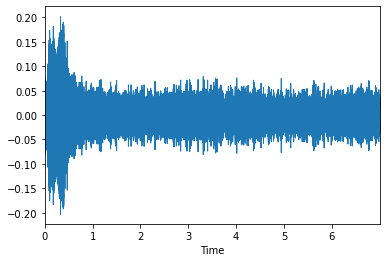

In [17]:
librosa.display.waveplot(raw_audio_next[0][:7*sampling_rate], sr=sampling_rate)

In [18]:
len(raw_audio_next)

52500

### CLipping and Taking first 7sec

In [19]:
labels = np.unique(meta_data['species'])
spectr_time_len = 7
idx_use = []
ctr = 0
for lbl in labels:
    idx_label = meta_data.loc[meta_data['species'] == lbl].index
    useful = []
    for ii in idx_label:
        if len(raw_audio_next[ii])>=spectr_time_len*sampling_rate:
            useful.append(ii)
    if len(useful)>20:
        idx_use.extend(useful)
        ctr += 1
    if ctr == 105:
        break
metadata_clipped = meta_data.loc[idx_use].reset_index(drop=True)
clipped_audio = []
for idx in idx_use:
    # clipped_audio.append(meta_data[idx][:spectr_time_len*sampling_rate])
    clipped_audio.append(raw_audio_next[idx][:spectr_time_len * sampling_rate])


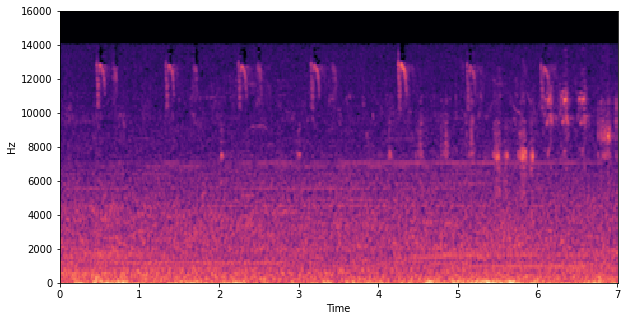

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
S = librosa.feature.melspectrogram(
            y = clipped_audio[1],
            sr = sampling_rate,
            n_mels=128,
    )
            # flip is done across vertically to make lower frequencies in the bottom part, as done
            # by the liborsa specshow
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='hz', sr = sampling_rate)
plt.show()

## Get Spectrogram

In [21]:
def get_spectr(audio, sampling_rate):
    S = librosa.feature.melspectrogram(
            y = audio,
            sr = sampling_rate,
            n_mels=128,
    )
            # flip is done across vertically to make lower frequencies in the bottom part, as done
            # by the liborsa specshow
    return np.flip(librosa.power_to_db(S, ref=np.max).astype('float32'), axis=0)

In [22]:
num_cores = multiprocessing.cpu_count()
spectr_clipped = Parallel(n_jobs=num_cores)(
                            delayed(get_spectr)(audio, sampling_rate)
                            for audio in clipped_audio
                )

In [23]:
spectr_clipped = np.array(spectr_clipped)

### Saving clipped Audio spectrogram

In [24]:
file_name = f'birds_xeno_spectr_100_species_sr_32000_len_{spectr_time_len}_sec_New.h5'
hf = h5py.File(os.path.join(dataDir,
                file_name), 'w')
grp = hf.create_dataset('mel_spectr', data=spectr_clipped)
hf.close()
metadata_clipped.to_hdf(os.path.join(dataDir,
            file_name), key='info')

### Sliding window spectrogram

In [25]:
win_len = 500 # in ms
win_slide_len = 250 # in ms

In [26]:
def get_sliding_spectr(full_audio, win_len, win_slide_len, sampling_rate):
    num_windows_max_possible = int((7000-win_len)/win_slide_len)

    win_ind = 0
    spectr_try = get_spectr(full_audio[win_ind*int(win_slide_len/1000*sampling_rate):win_ind*int(win_slide_len/1000*sampling_rate)+int(win_len/1000 * sampling_rate)],
                                                 sampling_rate)
    spectr_slides = np.empty((num_windows_max_possible, np.shape(spectr_try)[0], np.shape(spectr_try)[1]))
    for win_ind in range(num_windows_max_possible):
        spectr_slides[win_ind,:] = get_spectr(full_audio[win_ind*int(win_slide_len/1000*sampling_rate):win_ind*int(win_slide_len/1000*sampling_rate)+int(win_len/1000 * sampling_rate)],
                                                 sampling_rate)
    return spectr_slides
    
num_cores = multiprocessing.cpu_count()

spectr_clipped_slide = Parallel(n_jobs=num_cores)(
                            delayed(get_sliding_spectr)(audio, win_len, win_slide_len, sampling_rate) 
                            for audio in clipped_audio)

In [27]:
spectr_clipped_slide = np.array(spectr_clipped_slide)

### Saving Sliding window spectrogram

In [28]:
file_name = f'birds_xeno_spectr_slide_105_species_sr_32000_len_{spectr_time_len}_sec_{win_len}_{win_slide_len}_New.h5' 
hf = h5py.File(os.path.join(dataDir,
                file_name), 'w')
grp = hf.create_dataset('mel_spectr', data=spectr_clipped_slide)
hf.close()
metadata_clipped.to_hdf(os.path.join(dataDir,
            file_name), key='info')

### Testing

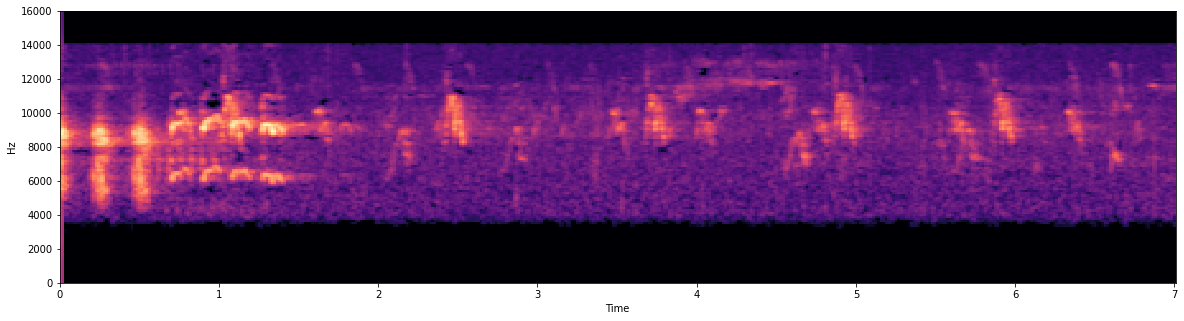

In [29]:
idx_spectr = 10
plt.figure(figsize=(20, 5))
S = np.flipud(spectr_clipped[idx_spectr])
librosa.display.specshow(S, x_axis='time', y_axis='hz', sr = sampling_rate)
plt.show()

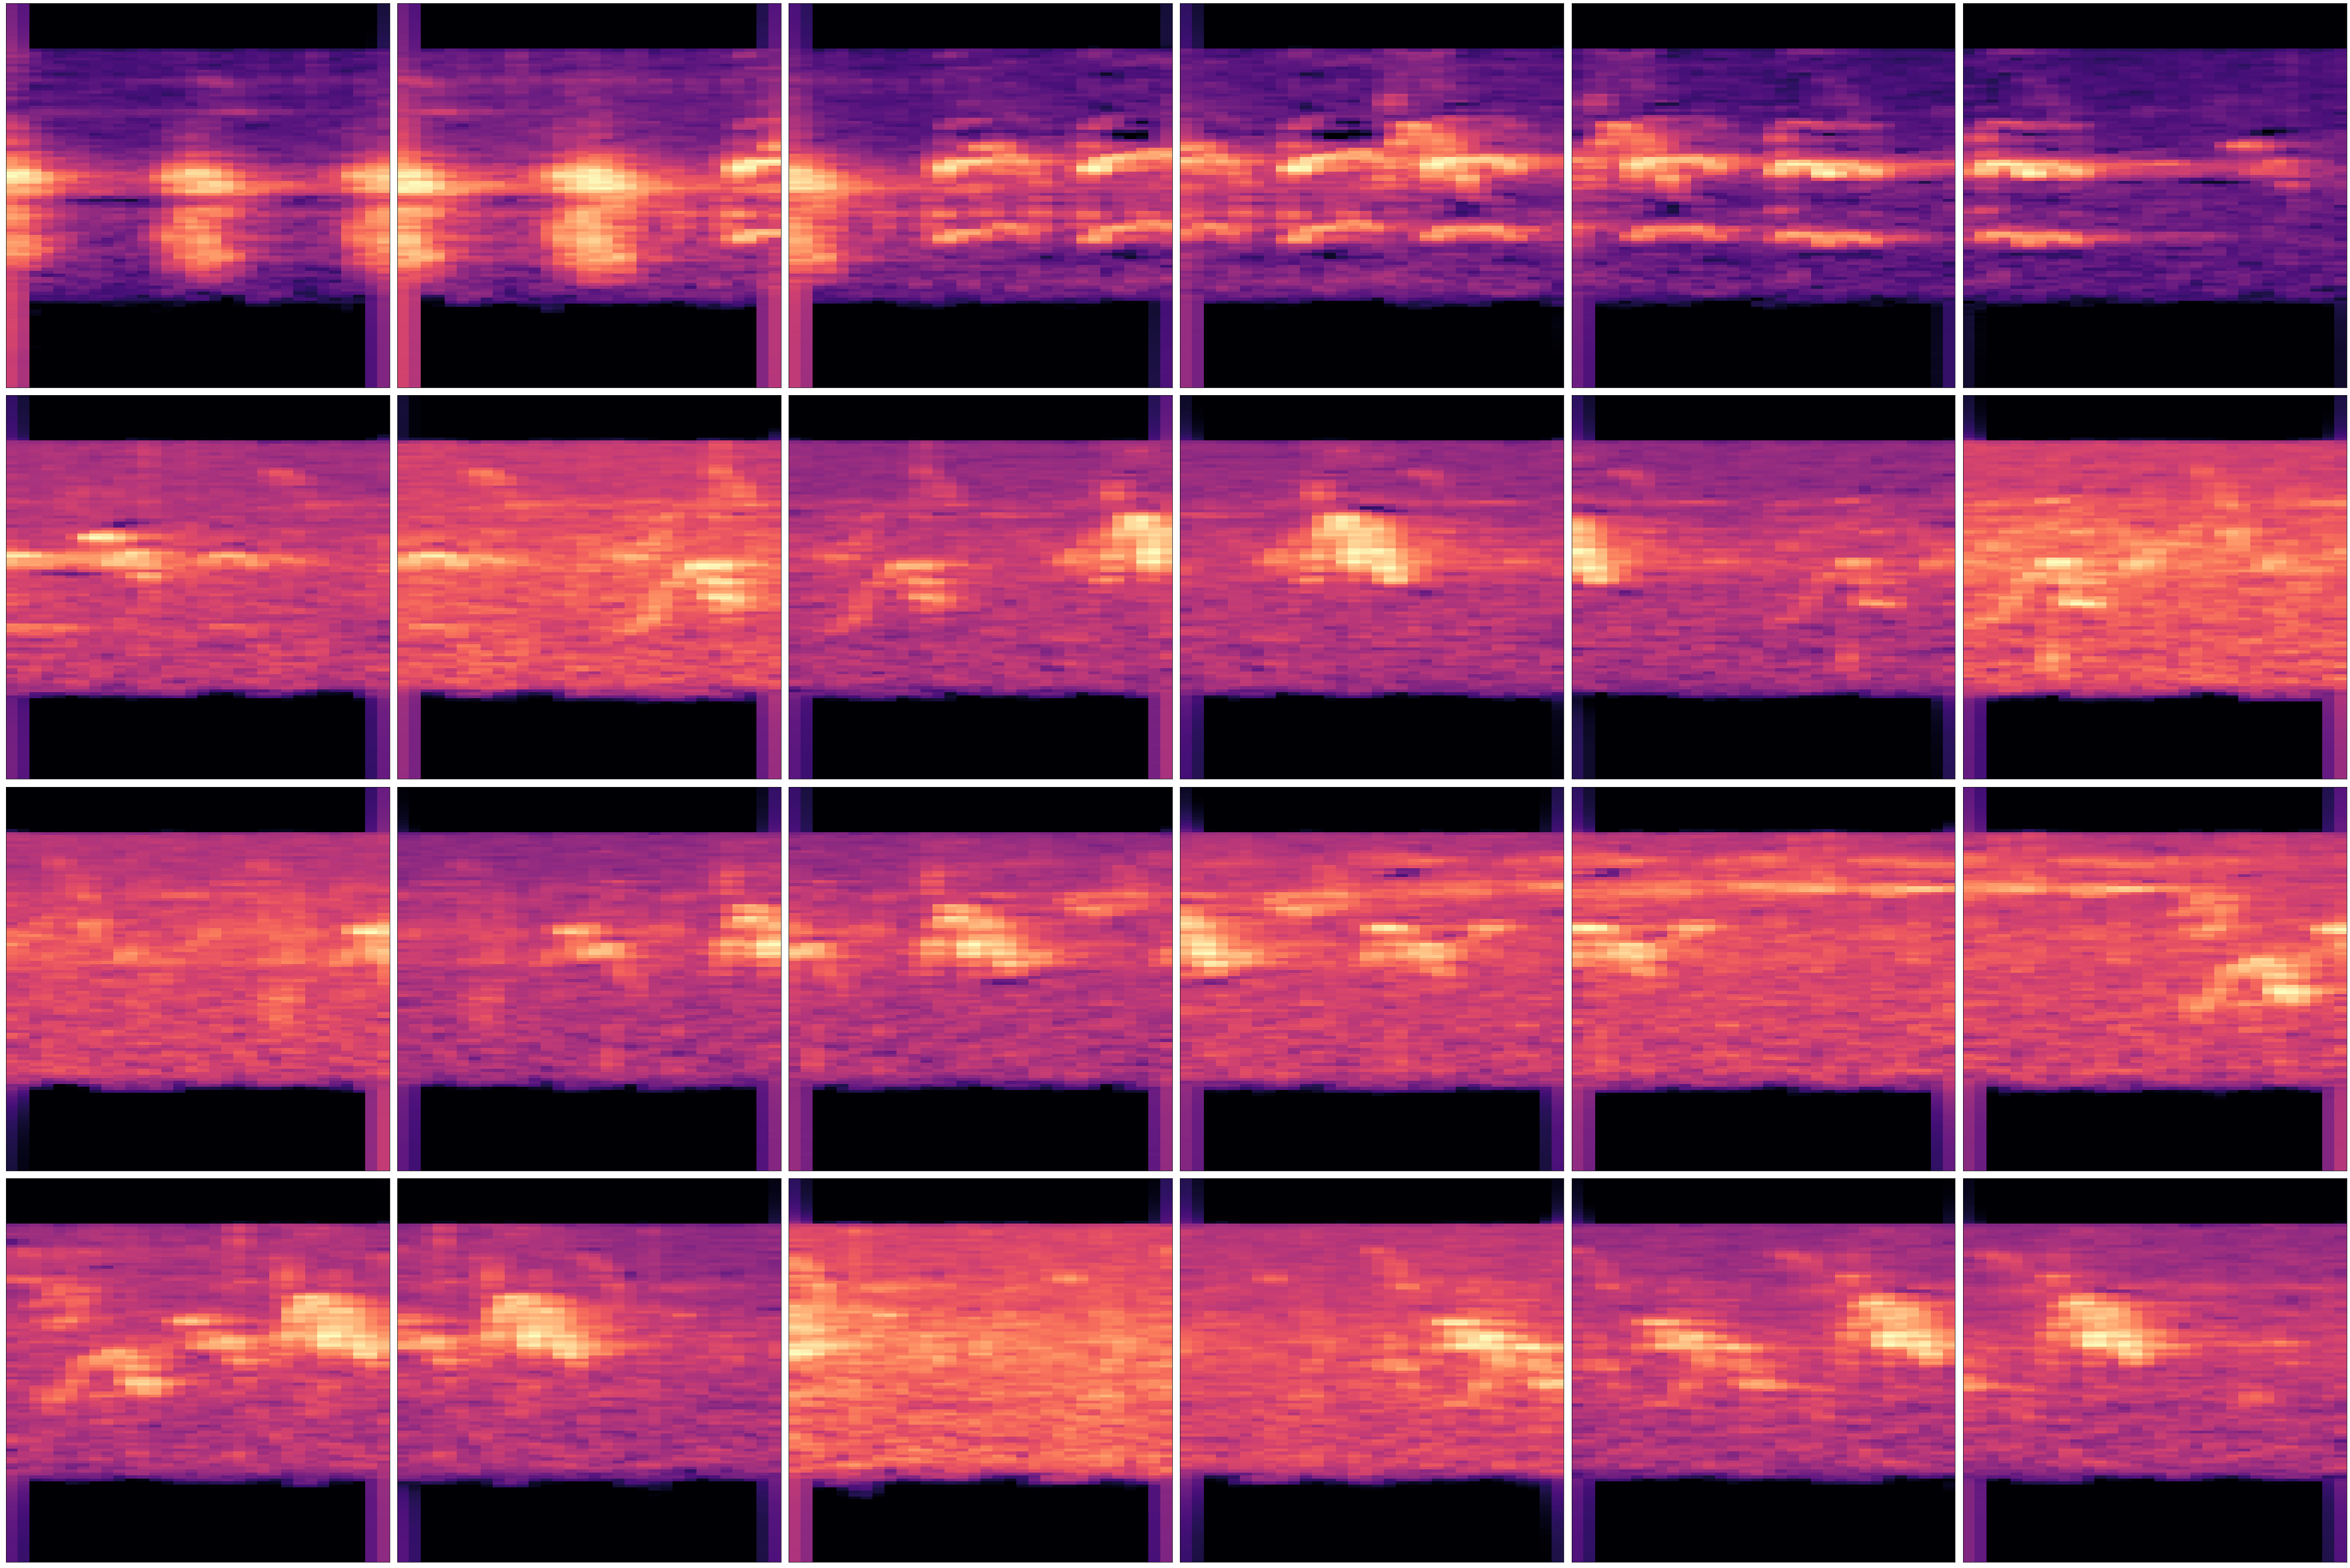

In [30]:
num_windows = 24
max_plt_per_row = 6
plt.figure(figsize=(int(2.5*num_windows), 10*(num_windows//max_plt_per_row +1))) 
for i in range(num_windows):
    plt.subplot(num_windows//max_plt_per_row +1, max_plt_per_row, i+1)
    win_ind = i
    S = spectr_clipped_slide[idx_spectr][i,:,:]
    librosa.display.specshow(np.flipud(S))
    plt.tight_layout()

plt.show()